Antes de nada nos importamos las librerias necesarias.

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler
from pyspark.sql import SparkSession, functions as F, types, Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs

Iniciamos la sesion spark

In [3]:
sparkConf = SparkSession\
        .builder\
        .appName("Spark ML Clustering")\
        .getOrCreate()

Quitamos los mensajes de log de las ejecuciones de celdas

In [3]:
#logger = sparkConf._jvm.org.apache.log4j
#logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)
#logger.LogManager.getLogger("org").setLevel(logger.Level.INFO)

Cargamos los datos del archivo csv original con datos desde 2001 hasta 2021 de delitos en la ciudad de Chicago

In [4]:
chicago_raw= sparkConf\
    .read\
    .format("csv")\
    .option("header", "true")\
    .load("..\Datasets\crimes.csv")

Mostramos el dataset

In [5]:
chicago_raw.printSchema()
# Otras formas de previsualizar un conjunto de datos:
#chicago_raw.columns
#chicago_raw.count()
#chicago_raw.show(10)

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



Cogemos las columnas que nos interesan, para nuestro proyecto hemos elegido las siguientes:

In [6]:
chicago_raw=chicago_raw.select("ID","Date","Primary Type","Arrest","Domestic","District","Latitude","Longitude")

Transformamos la columna de fecha con tipo string a tipo timestamp. 

* Nota: no es posible pasar de string a tipo date en un solo paso, por lo que usamos timestamp como paso intermedio.

In [5]:
chicago_raw = chicago_raw.withColumn("Date", F.to_timestamp(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

Ahora si, lo pasamos a tipo fecha y lo visualizamos para comprobar que queda un dataframe legible con los campos que utilizaremos.

In [7]:
chicago_raw = chicago_raw.withColumn("Date", F.to_date(F.unix_timestamp("Date", "M/dd/yyyy hh:mm:ss a").cast("timestamp")))

In [8]:
chicago_raw.show(10)

+--------+----------+------------------+------+--------+--------+------------+-------------+
|      ID|      Date|      Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+------------------+------+--------+--------+------------+-------------+
|10224738|2015-09-05|           BATTERY| false|    true|     009|41.815117282|-87.669999562|
|10224739|2015-09-04|             THEFT| false|   false|     015|41.895080471|-87.765400451|
|11646166|2018-09-01|             THEFT| false|    true|     006|        null|         null|
|10224740|2015-09-05|         NARCOTICS|  true|   false|     014|41.937405765|-87.716649687|
|10224741|2015-09-05|           ASSAULT| false|    true|     015|41.881903443|-87.755121152|
|10224742|2015-09-05|          BURGLARY| false|   false|     006|41.744378879|-87.658430635|
|10224743|2015-09-04|          BURGLARY| false|   false|     014|41.914635603|-87.681630909|
|10224744|2015-09-05|             THEFT|  true|   false|     010|41.85

Quitamos las filas con valores nulos del dataset comprobando cuantos registros hay antes y despues de quitar los nulos.

* Nota: tenemos 74.796 registros nulos de un total inicial de 7.433.155. Es decir, un 1% de los registros son nulos.

In [9]:
chicago_raw.count()

7433155

In [10]:
chicago_raw=chicago_raw.na.drop()

In [11]:
chicago_raw.count()

7358359

En el dataset se aprecia que existen algunos delitos cuya latitud y longitud se encuentran bastante alejados de la ciudad de Chicago. Hemos filtrado para buscar aquellos que están fuera del rango "aceptable" de la ciudad de Chicago. Abarcamos parcialmente el área metropolitana y son muy pocos los registros que están fuera de la ciudad. Se consideran datos erroneos y se sacan del dataframe para no distorsionar el proceso clustering y las agrupaciones posteriores.

* Nota: Son 116 registros y todos están localizados en el mismo punto. Como vemos en la imagen, están fuera de la ciudad de Chicago y más cerca de otras ciudades.

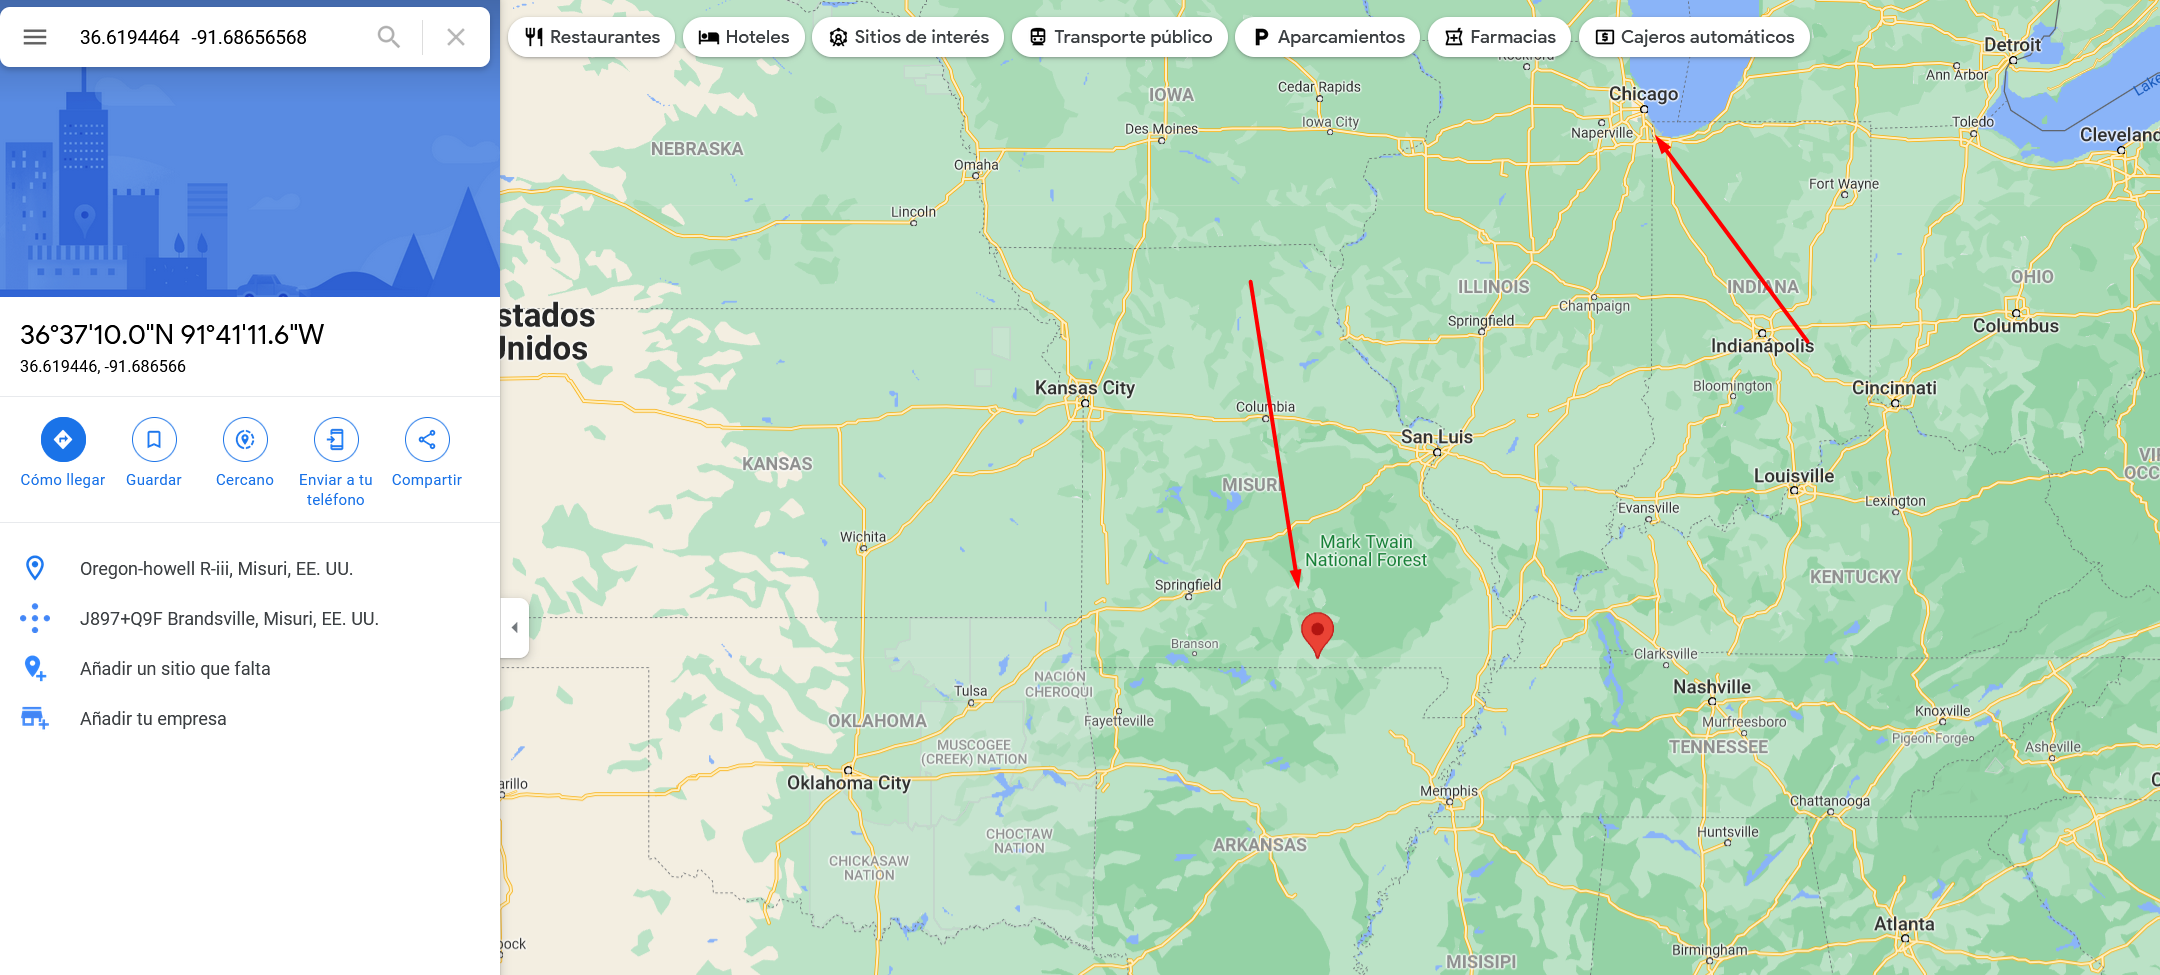

In [12]:
registro_outlier = chicago_raw.filter(chicago_raw['Latitude'] == 36.619446395)

In [13]:
registro_outlier.count()

116

In [14]:
registro_outlier.show()

+--------+----------+--------------------+------+--------+--------+------------+-------------+
|      ID|      Date|        Primary Type|Arrest|Domestic|District|    Latitude|    Longitude|
+--------+----------+--------------------+------+--------+--------+------------+-------------+
|    1051|2001-09-03|            HOMICIDE|  true|   false|     010|36.619446395|-91.686565684|
|    1206|2001-11-11|            HOMICIDE| false|   false|     011|36.619446395|-91.686565684|
| 6063108|2008-01-30|             ROBBERY| false|   false|     009|36.619446395|-91.686565684|
| 6125233|2008-02-15|  DECEPTIVE PRACTICE| false|   false|     016|36.619446395|-91.686565684|
| 6200282|2008-04-12|               THEFT| false|   false|     014|36.619446395|-91.686565684|
|11732417|2019-06-23|             BATTERY| false|    true|     011|36.619446395|-91.686565684|
| 6169464|2008-03-26| CRIM SEXUAL ASSAULT| false|   false|     014|36.619446395|-91.686565684|
| 6229358|2008-05-04|   WEAPONS VIOLATION|  true| 

Ahora dejamos en el dataframe únicamente con los datos que vamos a procesar. 

* Nota: nos quedamos con un total de 7.358.243 registros que no son nulos ni outliers. 

In [14]:
chicago_raw = chicago_raw.filter((chicago_raw['Latitude'] <= 42.221944) | 
                                    (chicago_raw['Longitude'] >= -87.967778) | 
                                    (chicago_raw['Latitude'] >= 41.541944) | 
                                    (chicago_raw['Longitude'] <= -87.287778))

In [13]:
chicago_raw.count()

7358243

Cambiamos el tipo de las columnas Latitude y Longitude a double y las de Arrest y Domestic que son booleanas a Integer 

In [15]:
chicago_raw = chicago_raw.withColumn("Latitude", chicago_raw["Latitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Longitude", chicago_raw["Longitude"].cast(types.DoubleType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.BooleanType()))
chicago_raw = chicago_raw.withColumn("Arrest", chicago_raw["Arrest"].cast(types.IntegerType()))
chicago_raw = chicago_raw.withColumn("Domestic", chicago_raw["Domestic"].cast(types.IntegerType()))
chicago_raw = chicago_raw.withColumn("District", chicago_raw["District"].cast(types.IntegerType()))
#chicago_raw.printSchema()

Añadimos al dataframe una columna de características que representa lat y long en forma de vector para realizar el clustering sobre estas variables.

In [16]:
assemble=VectorAssembler(inputCols=[
 'Latitude',
 'Longitude'], outputCol='features')

assembled_data=assemble.transform(chicago_raw)

#assembled_data.show(2)

Hacemos un estudio que determine el número óptimo de clusters a utilizar en función del parámetro Silhouette.


* Nota: Silhouette indica como de cerca esta cada punto a su centroide respectivo. Oscila entre -1 y 1, siendo cuanto más cercano a uno mejor. Indicaría que cada punto (registro) se va asocia potencialmente solo con los registros de su propio cluster.


* Nota 2: Por defecto el método que utiliza el K-Means para calcular distancias es la distancia euclídea, revisando la documentación de la librería SparkML hemos comprobado que entre los métodos disponibles no está la distancia a Manhattan que fue nuestra principal opción a considerar dado lo eficiente y rápido que son los cálculos con este método ya que no es necesario hacer potencias ni raices cuadradas (que computacionalmente es muy costoso).

Este sería el resultado del estudio para clusters entre 2 y 10 centroides:

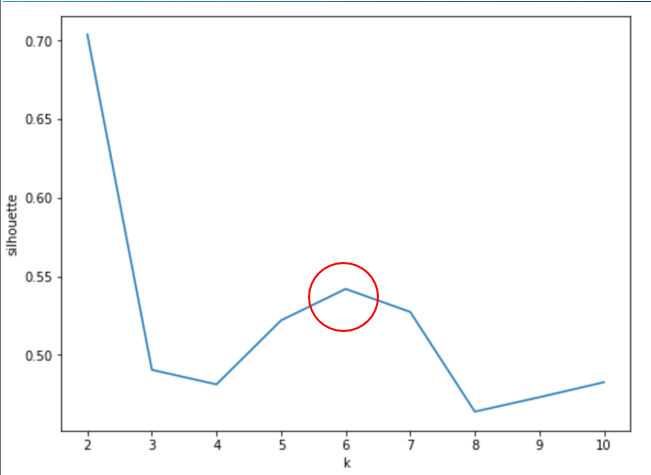

Ahora repetiremos el estudio para los rangos [11,20] y [21,30] con el fin de determinar que número de clusters sería optimo aplicar en función de Silhouette.

In [104]:
silhouette_score=[]
evaluator = ClusteringEvaluator()
prediction_max = None
centroids_max = None
score_max = 0


for i in range(10,21):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(assembled_data)    
    output=KMeans_fit.transform(assembled_data) 
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    if(score > score_max):
        prediction_max = output
        centroids_max = KMeans_fit.clusterCenters()
        score_max = score
    
    print("Silhouette Score:",score,"i=",i)

Silhouette Score: 0.49205955554557795 i= 10
Silhouette Score: 0.5444808623932896 i= 11
Silhouette Score: 0.546314016094265 i= 12
Silhouette Score: 0.5404772346108718 i= 13
Silhouette Score: 0.5470369759309137 i= 14
Silhouette Score: 0.5562680960051609 i= 15
Silhouette Score: 0.5526647778686206 i= 16
Silhouette Score: 0.5413358616626154 i= 17
Silhouette Score: 0.5440012553306598 i= 18
Silhouette Score: 0.5449947219115913 i= 19
Silhouette Score: 0.5407585808891094 i= 20


In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(10,21),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('silhoutte')

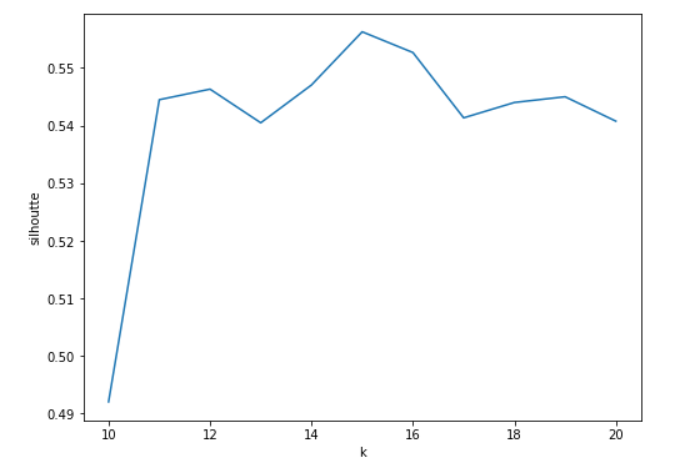

In [57]:
silhouette_score30=[]
evaluator30 = ClusteringEvaluator()
prediction_max30 = None
centroids_max30 = None
score_max30 = 0


for i in range(21,31):
    
    KMeans_algo30=KMeans(featuresCol='features', k=i)
    
    KMeans_fit30=KMeans_algo30.fit(assembled_data)    
    output30=KMeans_fit30.transform(assembled_data) 
    
    score30=evaluator30.evaluate(output30)
    
    silhouette_score30.append(score30)
    
    if(score30 > score_max30):
        prediction_max30 = output30
        centroids_max30 = KMeans_fit30.clusterCenters()
        score_max30 = score30
    
    print("Silhouette Score:",score30,"i=",i)

Silhouette Score: 0.5439370142322393 i= 21
Silhouette Score: 0.5400081063973012 i= 22
Silhouette Score: 0.5592254558122508 i= 23
Silhouette Score: 0.5495497056030424 i= 24
Silhouette Score: 0.5365775679079144 i= 25
Silhouette Score: 0.5507086840398722 i= 26
Silhouette Score: 0.5392060407883819 i= 27
Silhouette Score: 0.5370101120449307 i= 28
Silhouette Score: 0.5385754645911116 i= 29
Silhouette Score: 0.5513085359937699 i= 30


Text(0, 0.5, 'silhoutte')

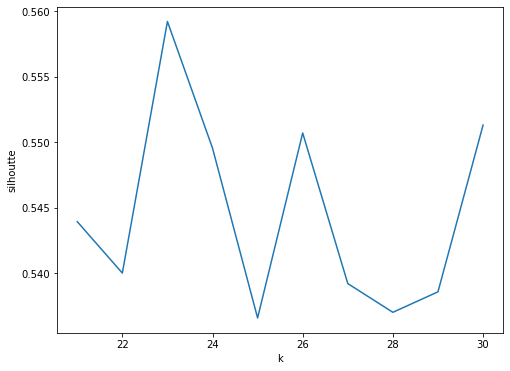

In [59]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(21,31),silhouette_score30)
ax.set_xlabel('k')
ax.set_ylabel('silhoutte')

Se utilizarán 15 clusters para entrenar nuestro modelo final dado que usar más clusters sería computacionalmente más costoso y no se obtendrían beneficios en cuanto a la puntuación Silhouette.

In [20]:
#Entrenamos el modelo Kmeans
kmeans = KMeans(featuresCol='features').setK(15).setSeed(1)
model = kmeans.fit(assembled_data)

# Hacemos las predicciones
predictions = model.transform(assembled_data)

# Evaluamos el cluster
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostramos los resultados
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
     print(center)

Silhouette with squared euclidean distance = 0.5541350729682784
Cluster Centers: 
[ 41.78271802 -87.72886713]
[ 41.99125492 -87.68393068]
[ 41.8912409  -87.75322945]
[ 41.74007018 -87.56384642]
[ 41.86296447 -87.7070921 ]
[ 41.9760997  -87.85491963]
[ 41.82045956 -87.62234363]
[ 41.68911972 -87.62759562]
[ 41.78623041 -87.66947071]
[ 41.76531267 -87.60885543]
[ 41.94371185 -87.65816369]
[ 41.73796693 -87.65701981]
[ 41.91482353 -87.70769658]
[ 41.94793551 -87.76406725]
[ 41.88673599 -87.63975014]


Exportamos a csv los centroides. El índice de la lista indica el cluster al que pertenece.

In [21]:
df = pd.DataFrame(columns=['Latitude_C', 'Longitude_C'])
for center in centers:
    df.loc[len(df)] = [center[0], center[1]]

df.to_csv('..\Datasets\centroides.csv', index_label = 'Cluster')

Cargamos los centroides en un dataframe

In [18]:
centroides= sparkConf\
    .read\
    .format("csv")\
    .option("header", "true")\
    .load("..\Datasets\centroides.csv")

Ahora guardamos los parámetros más interesantes de las predicciones obtenidas tras el Clustering y añadimos la latitud y longitud de su centroide.

* Nota: Esto lo hacemos para luego poder agrupar y disponer de la ubicación de los centroides que pintaremos sobre el mapa.

In [ ]:
predictions_processed1 = predictions[['ID','Primary Type','Arrest','Domestic','District','prediction','Latitude','Longitude']]

In [24]:
predictions_processed1 = predictions_processed1.withColumnRenamed("prediction","Cluster")

In [25]:
predictions_processed1 =  predictions_processed1.join(centroides, on = 'Cluster')

In [26]:
predictions_processed1.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\Resultados")

Importamos el csv de predicciones procesadas para no tener que realizar el clustering cada vez que cerramos la sesión de trabajo.

In [27]:
chicago_procesed= sparkConf\
    .read\
    .format("csv")\
    .option("header", "true")\
    .load("..\Datasets\procesado.csv")

Agregamos y procesamos el dataframe para trabajar con uno más ligero y manejable, es decir, con menos filas. 

* Nota: Esto nos permite un desarrollo más ágil y menor tiempo de computo en los pasos posteriores, incluyendo el explotado visual de los datos.

In [29]:
chicago_procesed_agg_KPI = chicago_procesed.groupBy('Primary Type','Arrest','Domestic','District','Cluster') \
.count() \
.withColumnRenamed("count","num_crimes")

In [30]:
chicago_procesed_agg_KPI.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\KPI")

In [31]:
chicago_procesed_agg_KPI= sparkConf\
    .read\
    .format("csv")\
    .option("header", "true")\
    .load("..\Datasets\df_kpi.csv")

In [35]:
chicago_procesed_agg_KPI = chicago_procesed_agg_KPI.withColumn("num_crimes", chicago_procesed_agg_KPI["num_crimes"].cast(types.IntegerType()))

Como resultado de sta agregación y procesado obtenemos un dataframe explotable aunque los datos siguiesen escalando. A continuación se valida los resultados del dataframe agregado:

In [32]:
chicago_procesed_agg_KPI.show(10)

+--------------------+------+--------+--------+-------+----------+
|        Primary Type|Arrest|Domestic|District|Cluster|num_crimes|
+--------------------+------+--------+--------+-------+----------+
|   CRIMINAL TRESPASS|     1|       0|       1|     14|     10963|
|             BATTERY|     1|       0|      17|     13|      1762|
|             ROBBERY|     0|       0|      24|      1|      7543|
|            BURGLARY|     0|       0|      15|      2|      9843|
|             ROBBERY|     0|       0|      25|     13|      4501|
|             ASSAULT|     0|       0|       4|      9|      1364|
|     CRIMINAL DAMAGE|     0|       1|      11|      2|      1434|
|INTERFERENCE WITH...|     1|       0|      25|     12|       345|
|INTERFERENCE WITH...|     1|       0|      22|      7|       212|
|               THEFT|     0|       0|       7|      6|       570|
+--------------------+------+--------+--------+-------+----------+
only showing top 10 rows



In [33]:
chicago_procesed_agg_KPI.count()

5704

Se hacen validaciones para comprobar si un mismo distrito se encuentra en varios clusters, esto se hace para reforzar la decisión de tomar 15 Clusters junto con la visualización de los resultados.

In [36]:
chicago_procesed_agg_KPI_2 = chicago_procesed_agg_KPI.groupBy('District','Cluster').sum('num_crimes').withColumnRenamed("sum(num_crimes)","num_crimes")

In [37]:
chicago_procesed_agg_KPI_2.show(10)

+--------+-------+----------+
|District|Cluster|num_crimes|
+--------+-------+----------+
|      31|      3|        13|
|      31|      7|         3|
|       9|      4|     28413|
|      31|      1|        27|
|      12|      7|         1|
|      20|     10|     23126|
|      15|      0|         1|
|      31|     11|        19|
|       7|      1|         1|
|      31|     13|         6|
+--------+-------+----------+
only showing top 10 rows



Aqui comprobamos a cuantos clusters se asocian los delitos cometidos en un único distrito.

In [38]:
chicago_procesed_agg_KPI_2.filter(chicago_procesed_agg_KPI_2.District  == "31")\
    .show(truncate=False)

+--------+-------+----------+
|District|Cluster|num_crimes|
+--------+-------+----------+
|31      |3      |13        |
|31      |7      |3         |
|31      |1      |27        |
|31      |11     |19        |
|31      |13     |6         |
|31      |14     |1         |
|31      |12     |3         |
|31      |8      |7         |
|31      |9      |2         |
|31      |5      |125       |
|31      |2      |9         |
|31      |10     |2         |
|31      |4      |1         |
+--------+-------+----------+



Se van a representar los clusters mediante muestreo aleatorio de delitos, pero para representar los centroides y el área que abarcarían utilizaremos circunferencias que se calculan a continuación:

In [39]:
poligonos=chicago_procesed[['Cluster','Latitude', 'Longitude','Latitude_C', 'Longitude_C']]
#poligonos.show(10)

In [40]:
poligonos.count()

7358243

In [41]:
poligonos_processed = poligonos.groupBy('Cluster','Latitude', 'Longitude','Latitude_C', 'Longitude_C') \
.count() \
.withColumnRenamed("count","num_crimes")

#poligonos_processed.show(2)

In [42]:
poligonos_processed.count()

880734

In [43]:
poligonos_processed = poligonos_processed.withColumn("Latitude", poligonos_processed["Latitude"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Longitude", poligonos_processed["Longitude"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Latitude_C", poligonos_processed["Latitude_C"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Longitude_C", poligonos_processed["Longitude_C"].cast(types.DoubleType()))
poligonos_processed = poligonos_processed.withColumn("Cluster", poligonos_processed["Cluster"].cast(types.IntegerType()))

Para dibujar las circunferencias necesitamos conocer la latitud y longitud de los cetroides que antes incluimos en el dataframe procesado junto con un radio. 


Para el radio necesitamos calcular la distancia en metros. La distancia que se utiliza es la media de las distancias de os puntos donde se han cometido delitos. Estas distancias medias se hacen por cada cluster. Finalmente tendremos 15 centroides y 15 radios calculados con las distancias medias de sus puntos delictivos.

En Spark esto se puede hacer creando dos columnas de características, una para los puntos del delito y otra para los puntos de su centroide respectivo. 

In [44]:
assemble2=VectorAssembler(inputCols=[

 'Latitude',
 'Longitude'], outputCol='features')

assembled_data2=assemble2.transform(poligonos_processed)

#assembled_data2.show(2)

In [45]:
assemble3=VectorAssembler(inputCols=[

 'Latitude_C',
 'Longitude_C'], outputCol='features_C')

assembled_data3=assemble3.transform(assembled_data2)

#assembled_data3.show(2)

Dado que los puntos (centroides y cada punto delictivo) están en coordenadas geográficas a las distancias que se calculan deberán ser transformadas de grados a metros con una función ad hoc:

In [47]:
distance_udf = F.udf(lambda x,y: float(hs.haversine(x, y,unit=hs.Unit.METERS)), types.FloatType())

Aplicamos la función al dataframe para las columnas de características que luego se eliminarán del dataframe.

In [48]:
poligonos_processed = assembled_data3.withColumn('Distances', distance_udf(F.col('features'),F.col('features_C')))

In [49]:
poligonos_processed = poligonos_processed[['Cluster','Latitude_C', 'Longitude_C','Distances','Latitude', 'Longitude']]

Se utilizará un dataframe que contenga exclusivamente centroides y radios calculados con la distancia media. Lo agregamos para dicho cálculo medio.

In [80]:
Circulos = poligonos_processed.groupby('Cluster','Latitude_C','Longitude_C').agg({"Distances":"avg"})\
    .withColumnRenamed("avg(Distances)","Distances")

In [84]:
Circulos.repartition(1)\
    .write.format("csv")\
    .mode("overwrite")\
    .option("header", "true")\
    .save("..\Datasets\Circulos")

Resumidamente, se tiene en ficheros csv los dataframes con la información que se explotará visualmente:

* Registros procesados que será necesario muestrear para explotar en los visuales (7,3M)
* Dataframe tipo "warehouse" con los KPIs más interesantes. Agregado para que una aplicación visual lo pueda explotar (800K)
* Circunferencias de clusters que simularán potenciales ubicaciones de comisarías (15)